In [2]:
import jieba
import tensorflow as tf
from collections import Counter
import re
import pandas as pd
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def stopwords(filepath):
    stopwords = [line.strip() for line in open(filepath,'r',encoding='utf-8').readlines()]
    return stopwords

"去除标点"
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub("",line)
    
    return line

"获取label"
def get_cat():
    cat = set()
    with open("cnews\cnews.train.txt",encoding='utf-8') as f:
        for i in f.readlines():
            text = i.split('\t')[0]
            cat.add(text)
    return list(cat)



"转换为字，并以csv格式输出"
def text_cut(data_path):

    with open(data_path+"dict_word",encoding='utf-8') as f:
        dict_word = eval(f.readline())
    
    cat = get_cat()
    
    text_cut_one(data_path+"cnews.train.txt",output_path=os.getcwd()+"\\cnews\\train_vocab.csv",dict_word=dict_word,cat=cat)
    text_cut_one(data_path+"cnews.test.txt",output_path=os.getcwd()+"\\cnews\\test_vocab.csv",dict_word=dict_word,cat=cat)
    text_cut_one(data_path+"cnews.val.txt",output_path=os.getcwd()+"\\cnews\\val_vocab.csv",dict_word=dict_word,cat=cat)
    
                
def text_cut_one(data_path,output_path,dict_word,cat):
    
    df = pd.DataFrame()
    
    labels = []
    texts = []
    
    with open(data_path,encoding='utf-8') as f:
        for i in f.readlines():
            label = i.split('\t')[0]
            labels.append(cat.index(label))
            text = i.split('\t')[1]
            text = remove_punctuation(text)
            l = jieba.lcut(text)
            texts.append(",".join(l))

    df['text'] = texts
    df['label'] = labels
    
    df.to_csv(output_path)
    print("完成！！")

In [4]:
text_cut("cnews/")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\陈琪\AppData\Local\Temp\jieba.cache
Loading model cost 0.733 seconds.
Prefix dict has been built successfully.


完成！！
完成！！
完成！！


In [5]:
vocab_size = 5000
embedding_dim = 128
max_length = 128
trunc_type = 'post' #从后截取
padding_type = 'post' #从后填充
unk_tok = '<unk>'

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,dropout=0.5)),
    tf.keras.layers.LSTM(embedding_dim,dropout=0.5),
    tf.keras.layers.Dense(embedding_dim,activation='relu'),#kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(11,activation='softmax')#,kernel_regularizer=tf.keras.regularizers.l2())
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1419      
Total params: 789,515
Trainable params: 789,515
Non-trainable params: 0
_________________________________________________________________


In [6]:
train = pd.read_csv("cnews/train_vocab.csv")
val = pd.read_csv("cnews/val_vocab.csv")
test = pd.read_csv("cnews/test_vocab.csv")

In [7]:
tokenizer = Tokenizer(num_words=vocab_size,split=',',oov_token=unk_tok)


In [8]:
tokenizer.fit_on_texts(train.text.values)
x_train_seq = tokenizer.texts_to_sequences(train.text.values)
x_train_pad = pad_sequences(x_train_seq,maxlen=max_length,padding=padding_type,truncating=trunc_type)

x_val_seq = tokenizer.texts_to_sequences(val.text.values)
x_val_pad = pad_sequences(x_val_seq,maxlen = max_length,padding=padding_type,truncating=trunc_type)

y_train = np.array(train.label.values)
y_val = np.array(val.label.values)


In [9]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [10]:
history = model.fit(x_train_pad,y_train,batch_size = 64,validation_data =(x_val_pad,y_val),epochs=10)

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
50000/50000 [==============================] - 176s 4ms/sample - loss: 1.6113 - accuracy: 0.4059 - val_loss: 2.2115 - val_accuracy: 0.2966
Epoch 2/10
50000/50000 [==============================] - 177s 4ms/sample - loss: 0.9234 - accuracy: 0.6900 - val_loss: 0.7988 - val_accuracy: 0.7378
Epoch 3/10
50000/50000 [==============================] - 186s 4ms/sample - loss: 0.5308 - accuracy: 0.8381 - val_loss: 0.6217 - val_accuracy: 0.8034
Epoch 4/10
50000/50000 [==============================] - 190s 4ms/sample - loss: 0.2710 - accuracy: 0.9232 - val_loss: 0.2931 - val_accuracy: 0.9110
Epoch 5/10
50000/50000 [==============================] - 191s 4ms/sample - loss: 0.1803 - accuracy: 0.9497 - val_loss: 0.3306 - val_accuracy: 0.9052
Epoch 6/10
50000/50000 [==============================] - 192s 4ms/sample - loss: 0.1436 - accuracy: 0.9603 - val_loss: 0.3532 - val_accuracy: 0.8930
Epoch 7/10
50000/50000 [===========================

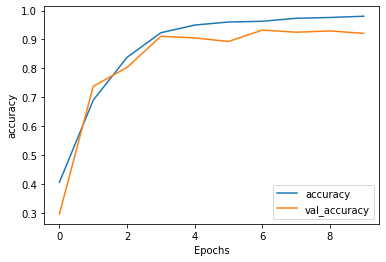

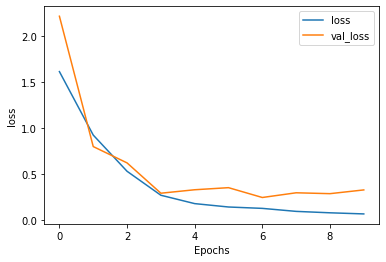

In [11]:
def plot_graphs(history, string):    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")